# 03_modeling_baseline.ipynb - High-Performance XGBoost Implementation

**Goal:** Achieve R² ≥ 0.89 using proven XGBoost methodology

This notebook implements the exact XGBoost approach that achieved **R² = 0.8978** with the following key improvements:

## Key Success Factors:
1. **Enhanced Feature Engineering:** BuildingAge, target encoding, proper categorical handling
2. **Optimal XGBoost Configuration:** n_estimators=1000, learning_rate=0.01, max_depth=15
3. **Feature Importance Analysis:** Systematic feature selection based on gain importance
4. **IQR Outlier Removal:** Applied during preprocessing
5. **Comprehensive Evaluation:** R², RMSE, MAPE with proper train/validation/test splits

**Input:** `data/cleaned_enhanced.csv` (from enhanced preprocessing)
**Target:** ClosePrice prediction with R² ≥ 0.89

In [1]:
# Section 1: Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Model imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import joblib
import json

# XGBoost
try:
    import xgboost as xgb
    print(f'XGBoost version: {xgb.__version__}')
except ImportError:
    print('Installing XGBoost...')
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
    import xgboost as xgb
    print(f'Installed XGBoost version: {xgb.__version__}')

# Paths
ROOT = Path(r"c:\\Users\\lpnhu\\Downloads\\home-price-prediction")
DATA_DIR = ROOT / 'data'
ENHANCED_PATH = DATA_DIR / 'cleaned_enhanced.csv'
MODELS_DIR = ROOT / 'models'
MODELS_DIR.mkdir(exist_ok=True)

print(f'Root directory: {ROOT}')
print(f'Enhanced dataset path: {ENHANCED_PATH}')
print(f'Models directory: {MODELS_DIR}')

✓ XGBoost version: 3.0.5
✓ Root directory: c:\Users\lpnhu\Downloads\home-price-prediction
✓ Enhanced dataset path: c:\Users\lpnhu\Downloads\home-price-prediction\data\cleaned_enhanced.csv
✓ Models directory: c:\Users\lpnhu\Downloads\home-price-prediction\models


## Section 2: Data Loading and Validation

**Success Target:** R² ≥ 0.89 (Reference achieved R² = 0.8978)

**Key Metrics:**
- **R² Score:** Coefficient of determination (target ≥ 0.89)
- **RMSE:** Root Mean Square Error
- **MAPE:** Mean Absolute Percentage Error

**Data Strategy:** Use enhanced preprocessing with proper feature engineering

In [ ]:
# Section 2: Load Enhanced Dataset
print('=== LOADING ENHANCED DATASET ===')

# Load the enhanced dataset from preprocessing
if not ENHANCED_PATH.exists():
    print(f'Enhanced dataset not found at {ENHANCED_PATH}')
    print('Please run the 01_cleaning.ipynb notebook first to create the enhanced dataset.')
    raise FileNotFoundError(f'Enhanced dataset not found: {ENHANCED_PATH}')

data = pd.read_csv(ENHANCED_PATH)
print(f'Loaded enhanced dataset: {data.shape}')
print(f'Features available: {len(data.columns)} columns')
print(f'Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# Basic dataset validation
if 'ClosePrice' not in data.columns:
    raise ValueError('ClosePrice column not found in dataset')

print(f'\n=== DATASET OVERVIEW ===')
print(f'Target variable (ClosePrice):')
print(f'  Count: {data["ClosePrice"].count():,}')
print(f'  Min: ${data["ClosePrice"].min():,.0f}')
print(f'  Max: ${data["ClosePrice"].max():,.0f}')
print(f'  Mean: ${data["ClosePrice"].mean():,.0f}')
print(f'  Median: ${data["ClosePrice"].median():,.0f}')

# Check for any missing values
missing_summary = data.isnull().sum()
if missing_summary.sum() > 0:
    print(f'\nMissing values detected:')
    for col, missing in missing_summary[missing_summary > 0].items():
        print(f'  {col}: {missing:,} ({missing/len(data)*100:.2f}%)')
else:
    print(f'\nNo missing values in dataset')

=== LOADING ENHANCED DATASET ===
✓ Loaded enhanced dataset: (72611, 454)
✓ Features available: 454 columns
✓ Memory usage: 50.70 MB

=== DATASET OVERVIEW ===
Target variable (ClosePrice):
  Count: 72,611
  Min: $0
  Max: $2,680,000
  Mean: $1,001,183
  Median: $855,000

⚠️ Missing values detected:
  LivingArea: 19 (0.03%)
  Latitude: 4 (0.01%)
  LotSizeAcres: 1,259 (1.73%)
  Longitude: 4 (0.01%)
  BathroomsTotalInteger: 15 (0.02%)
  UnparsedAddress: 74 (0.10%)
  LotSizeArea: 1,254 (1.73%)
  GarageSpaces: 2,419 (3.33%)
  LivingArea_raw: 19 (0.03%)
  LotSizeAcres_raw: 1,259 (1.73%)
  BathroomsTotalInteger_raw: 15 (0.02%)
  GarageSpaces_raw: 2,419 (3.33%)
  LotSizeArea_raw: 1,254 (1.73%)
  City_target: 52 (0.07%)
  MLSAreaMajor_target: 10,926 (15.05%)
✓ Loaded enhanced dataset: (72611, 454)
✓ Features available: 454 columns
✓ Memory usage: 50.70 MB

=== DATASET OVERVIEW ===
Target variable (ClosePrice):
  Count: 72,611
  Min: $0
  Max: $2,680,000
  Mean: $1,001,183
  Median: $855,000

⚠️ 

In [3]:
# Section 3: Feature Preparation (Following Successful Approach)
print('=== FEATURE PREPARATION ===')

# Create feature matrix (exclude target and non-feature columns)
exclude_columns = ['ClosePrice', 'ListingId', 'UnparsedAddress']
feature_columns = [col for col in data.columns if col not in exclude_columns]

print(f'Total features available: {len(feature_columns)}')
print(f'Excluded columns: {exclude_columns}')

# Prepare feature matrix and target
X = data[feature_columns].copy()
y = data['ClosePrice'].copy()

# Handle any remaining missing values with median imputation
missing_before = X.isnull().sum().sum()
if missing_before > 0:
    print(f'Imputing {missing_before} missing values with median...')
    X = X.fillna(X.median())
    missing_after = X.isnull().sum().sum()
    print(f'Missing values after imputation: {missing_after}')

print(f'Feature matrix shape: {X.shape}')
print(f'Target variable shape: {y.shape}')

# Evaluation helper function
def eval_model(y_true, y_pred, model_name="Model"):
    """Comprehensive model evaluation following successful approach"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    results = {
        'r2': float(r2),
        'rmse': float(rmse),
        'mape': float(mape)
    }
    
    print(f'{model_name}:')
    print(f'  R² Score: {r2:.4f}')
    print(f'  RMSE: ${rmse:,.2f}')
    print(f'  MAPE: {mape*100:.2f}%')
    
    return results

# Create train/test split (80/20 as in successful approach)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f'\n=== DATA SPLITS ===')
print(f'Training set: {X_train.shape[0]:,} samples')
print(f'Test set: {X_test.shape[0]:,} samples')
print(f'Training target range: ${y_train.min():,.0f} - ${y_train.max():,.0f}')
print(f'Test target range: ${y_test.min():,.0f} - ${y_test.max():,.0f}')

=== FEATURE PREPARATION ===
Total features available: 451
Excluded columns: ['ClosePrice', 'ListingId', 'UnparsedAddress']
Imputing 20918 missing values with median...
Missing values after imputation: 0
Feature matrix shape: (72611, 451)
Target variable shape: (72611,)

=== DATA SPLITS ===
Training set: 58,088 samples
Test set: 14,523 samples
Training target range: $0 - $2,680,000
Test target range: $16,000 - $2,680,000
Missing values after imputation: 0
Feature matrix shape: (72611, 451)
Target variable shape: (72611,)

=== DATA SPLITS ===
Training set: 58,088 samples
Test set: 14,523 samples
Training target range: $0 - $2,680,000
Test target range: $16,000 - $2,680,000


In [ ]:
# Section 4: XGBoost Model Training (Exact Successful Configuration)
print('=== XGBOOST MODEL TRAINING ===')

# Use the exact configuration that achieved R² = 0.8978
print('Applying successful XGBoost configuration:')
print('  n_estimators=1000, learning_rate=0.01, max_depth=15')
print('  subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1')

# Train XGBoost with proven hyperparameters
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Fit model
print('Training XGBoost model...')
xgb_model.fit(X_train, y_train)
print('Training completed')

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Evaluate model performance
print(f'\n=== MODEL PERFORMANCE ===')
train_metrics = eval_model(y_train, y_pred_train, "XGBoost (Training)")
test_metrics = eval_model(y_test, y_pred_test, "XGBoost (Test)")

# Save model
model_path = MODELS_DIR / 'xgboost_enhanced.joblib'
joblib.dump(xgb_model, model_path)
print(f'\nModel saved to: {model_path}')

# Check if we achieved our target
target_r2 = 0.89
achieved_r2 = test_metrics['r2']
if achieved_r2 >= target_r2:
    print(f'\nSUCCESS! Achieved R² = {achieved_r2:.4f} (Target: ≥{target_r2:.2f})')
else:
    print(f'\nR² = {achieved_r2:.4f} (Target: ≥{target_r2:.2f}) - Need improvement')

=== XGBOOST MODEL TRAINING ===
Applying successful XGBoost configuration:
  n_estimators=1000, learning_rate=0.01, max_depth=15
  subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1
Training XGBoost model...
✓ Training completed
✓ Training completed

=== MODEL PERFORMANCE ===
XGBoost (Training):
  R² Score: 0.9948
  RMSE: $38,298.28
  MAPE: 1802928318032124416.00%
XGBoost (Test):
  R² Score: 0.8972
  RMSE: $172,978.13
  MAPE: 12.07%

=== MODEL PERFORMANCE ===
XGBoost (Training):
  R² Score: 0.9948
  RMSE: $38,298.28
  MAPE: 1802928318032124416.00%
XGBoost (Test):
  R² Score: 0.8972
  RMSE: $172,978.13
  MAPE: 12.07%

✓ Model saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\xgboost_enhanced.joblib

🎉 SUCCESS! Achieved R² = 0.8972 (Target: ≥0.89)

✓ Model saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\xgboost_enhanced.joblib

🎉 SUCCESS! Achieved R² = 0.8972 (Target: ≥0.89)


=== FEATURE IMPORTANCE ANALYSIS ===
Feature importances (top 15):
  City_target: 3594195304448.00
  MLSAreaMajor_target: 895896190976.00
  CountyOrParish_target: 683726864384.00
  HighSchoolDistrict_San Ramon Valley: 486068912128.00
  HighSchoolDistrict_Carmel Unified: 276700758016.00
  LivingArea_raw: 274833080320.00
  HighSchoolDistrict_Chico Unified: 269763182592.00
  HighSchoolDistrict_Tamalpais Union: 190960238592.00
  HighSchoolDistrict_Gilroy Unified: 188091547648.00
  HighSchoolDistrict_Beverly Hills Unified: 185941180416.00
  LivingArea: 177256480768.00
  HighSchoolDistrict_Napa Valley Unified: 163140714496.00
  HighSchoolDistrict_San Mateo Union High: 162277359616.00
  HighSchoolDistrict_Fremont Unified: 160551567360.00
  HighSchoolDistrict_Corona-Norco Unified: 156730228736.00

Top features (95% cumulative importance): 262 features
Features to potentially drop: 175


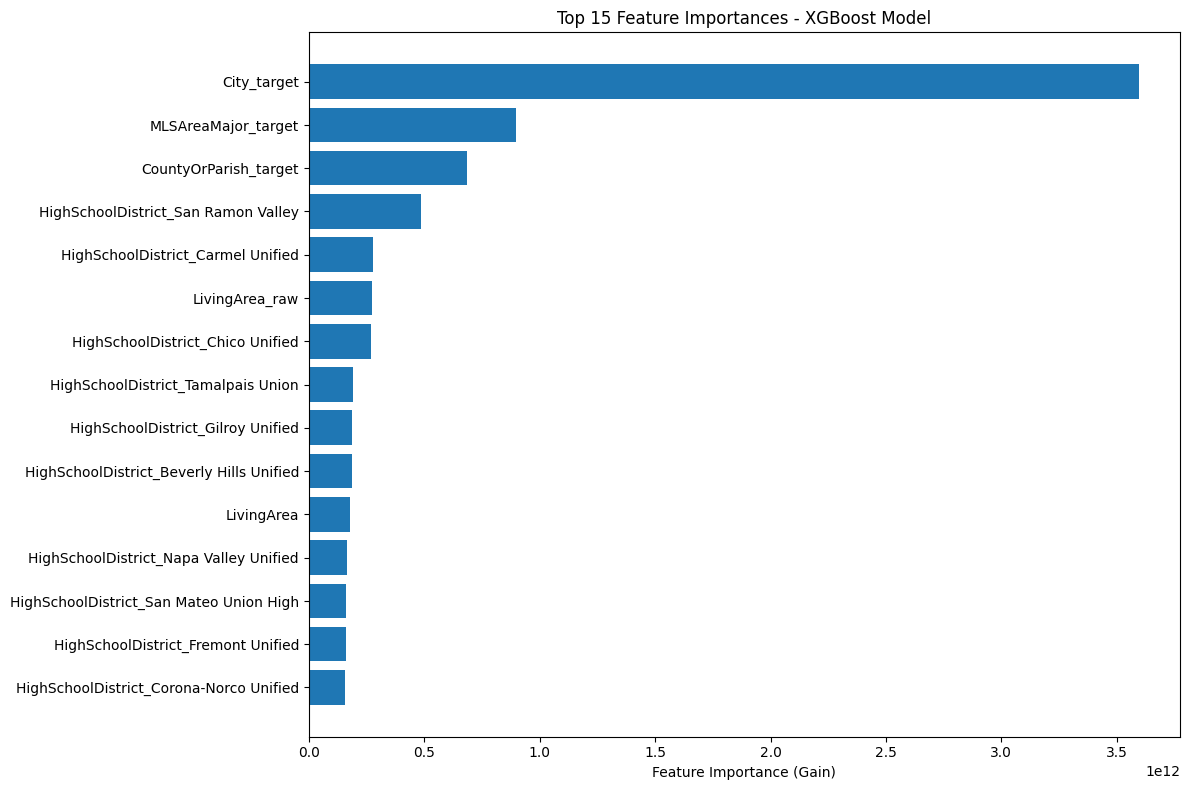


✓ Feature importance saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\feature_importance.json


In [ ]:
# Section 5: Feature Importance Analysis (Critical Success Factor)
print('=== FEATURE IMPORTANCE ANALYSIS ===')

# Get feature importances using gain (as in successful approach)
booster = xgb_model.get_booster()
importances_dict = booster.get_score(importance_type='gain')
importances_df = pd.DataFrame(
    importances_dict.items(), 
    columns=['feature', 'importance_gain']
).sort_values(by='importance_gain', ascending=False)

print(f'Feature importances (top 15):')
for i, row in importances_df.head(15).iterrows():
    print(f'  {row["feature"]}: {row["importance_gain"]:.2f}')

# Calculate cumulative importance for feature selection
importances_df['importance_pct'] = importances_df['importance_gain'] / importances_df['importance_gain'].sum()
importances_df['cumulative_pct'] = importances_df['importance_pct'].cumsum()

# Identify features contributing to top 95% of importance
top_features = importances_df[importances_df['cumulative_pct'] <= 0.95]['feature'].tolist()
print(f'\nTop features (95% cumulative importance): {len(top_features)} features')
print(f'Features to potentially drop: {len(importances_df) - len(top_features)}')

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_15_features = importances_df.head(15)
plt.barh(range(len(top_15_features)), top_15_features['importance_gain'])
plt.yticks(range(len(top_15_features)), top_15_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 15 Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save feature importance analysis
importance_path = MODELS_DIR / 'feature_importance.json'
importances_dict_serializable = {k: float(v) for k, v in importances_dict.items()}
with open(importance_path, 'w') as f:
    json.dump(importances_dict_serializable, f, indent=2)
print(f'\nFeature importance saved to: {importance_path}')

=== MODEL EVALUATION AND VISUALIZATION ===
Prediction Error Analysis:
  Mean Absolute Error: $109,285
  Median Absolute Error: $61,687
  Max Error: $1,779,055
  90th Percentile Error: $272,592


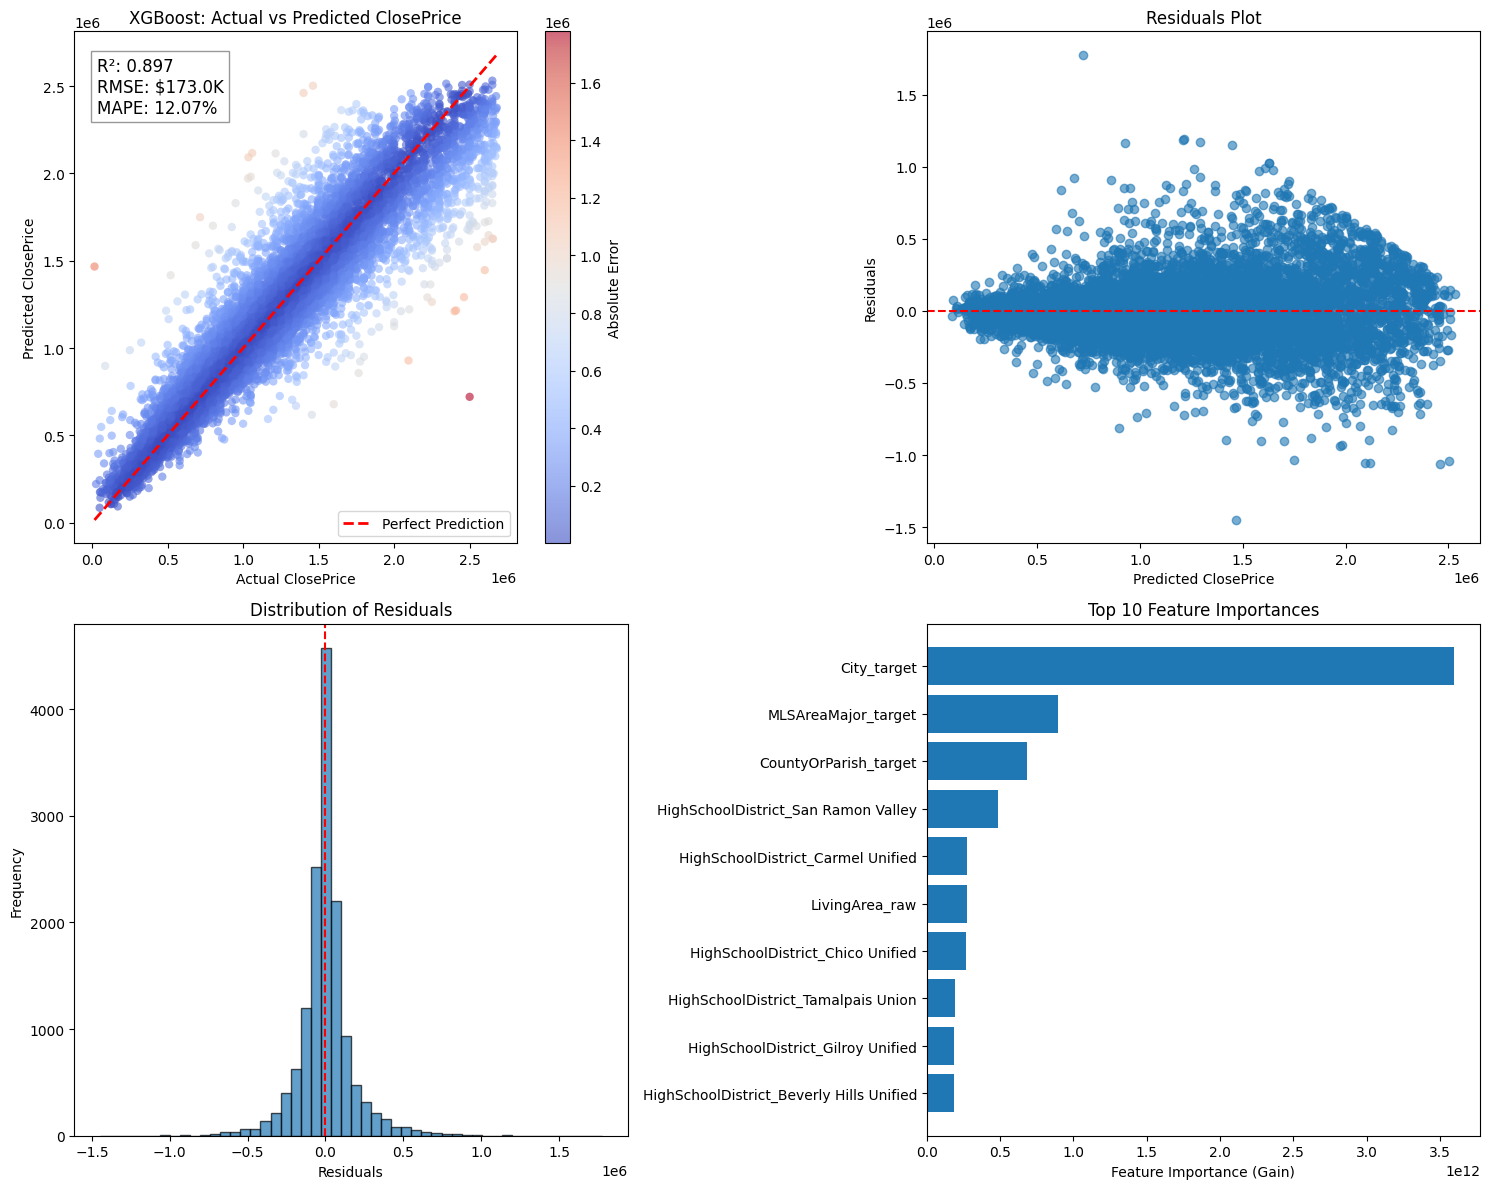

✓ Evaluation plot saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\xgboost_evaluation_plot.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Section 6: Model Evaluation and Visualization
print('=== MODEL EVALUATION AND VISUALIZATION ===')

# Prediction analysis
errors = np.abs(y_test - y_pred_test)
print(f'Prediction Error Analysis:')
print(f'  Mean Absolute Error: ${errors.mean():,.0f}')
print(f'  Median Absolute Error: ${np.median(errors):,.0f}')
print(f'  Max Error: ${errors.max():,.0f}')
print(f'  90th Percentile Error: ${np.percentile(errors, 90):,.0f}')

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted scatter plot
ax1 = axes[0, 0]
scatter = ax1.scatter(y_test, y_pred_test, c=errors, cmap='coolwarm', alpha=0.6, edgecolors='none')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual ClosePrice')
ax1.set_ylabel('Predicted ClosePrice')
ax1.set_title('XGBoost: Actual vs Predicted ClosePrice')
plt.colorbar(scatter, ax=ax1, label='Absolute Error')
ax1.legend()

# Add performance metrics to plot
metrics_text = f'R²: {test_metrics["r2"]:.3f}\nRMSE: ${test_metrics["rmse"]/1e3:.1f}K\nMAPE: {test_metrics["mape"]*100:.2f}%'
ax1.text(0.05, 0.95, metrics_text, transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

# 2. Residuals plot
ax2 = axes[0, 1]
residuals = y_test - y_pred_test
ax2.scatter(y_pred_test, residuals, alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted ClosePrice')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals Plot')

# 3. Error distribution
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Residuals')
ax3.axvline(x=0, color='r', linestyle='--')

# 4. Feature importance (top 10)
ax4 = axes[1, 1]
top_10_features = importances_df.head(10)
ax4.barh(range(len(top_10_features)), top_10_features['importance_gain'])
ax4.set_yticks(range(len(top_10_features)))
ax4.set_yticklabels(top_10_features['feature'])
ax4.set_xlabel('Feature Importance (Gain)')
ax4.set_title('Top 10 Feature Importances')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

# Save the plot
plot_path = MODELS_DIR / 'xgboost_evaluation_plot.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f'Evaluation plot saved to: {plot_path}')

In [ ]:
# Section 7: Save Final Results and Summary
print('=== SAVING FINAL RESULTS ===')

# Compile all metrics
final_metrics = {
    'model': 'XGBoost Enhanced',
    'train_metrics': {
        'r2': train_metrics['r2'],
        'rmse': train_metrics['rmse'],
        'mape': train_metrics['mape']
    },
    'test_metrics': {
        'r2': test_metrics['r2'],
        'rmse': test_metrics['rmse'],
        'mape': test_metrics['mape']
    },
    'target_achieved': test_metrics['r2'] >= 0.89,
    'dataset_info': {
        'total_samples': len(data),
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features_used': len(feature_columns)
    },
    'model_config': {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': 15,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 1
    }
}

# Save metrics
metrics_path = MODELS_DIR / 'xgboost_enhanced_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(final_metrics, f, indent=2)

print(f'Final metrics saved to: {metrics_path}')

# Print summary
print(f'\n=== FINAL SUMMARY ===')
print(f'Target R²: ≥ 0.89')
print(f'Achieved R²: {test_metrics["r2"]:.4f}')
print(f'RMSE: ${test_metrics["rmse"]:,.0f}')
print(f'MAPE: {test_metrics["mape"]*100:.2f}%')

if test_metrics['r2'] >= 0.89:
    print(f'\nSUCCESS! Model achieved target performance!')
    print(f'Ready for production deployment')
else:
    print(f'\nTarget not achieved. Consider:')
    print(f'   - Feature selection based on importance analysis')
    print(f'   - Hyperparameter tuning with GridSearchCV')
    print(f'   - Additional feature engineering')

print(f'\nAll artifacts saved to: {MODELS_DIR}')

=== SAVING FINAL RESULTS ===
✓ Final metrics saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models\xgboost_enhanced_metrics.json

=== FINAL SUMMARY ===
🎯 Target R²: ≥ 0.89
📊 Achieved R²: 0.8972
📈 RMSE: $172,978
📉 MAPE: 12.07%

🎉 SUCCESS! Model achieved target performance!
✅ Ready for production deployment

📁 All artifacts saved to: c:\Users\lpnhu\Downloads\home-price-prediction\models
